# CAT-DOG IMAGE CLASSIFIER

<p><b>Status: <span style=color:orange;>In Progress</span></b></p>

##### LOCATE IMAGE FILE NAMES
Cat : 0 | Dog : 1

In [1]:
import os
import pandas as pd
import numpy as np

data_dir = '../../../data/'
class_list = os.listdir(data_dir)  # get classes based on folder names

filename_list = []

# make a list of the images' file names, cats and dogs
for _class in class_list:
    filename_list_class = os.listdir(data_dir + _class)
    filename_list_class = [(_class + '/' + fname) for fname in filename_list_class if fname.endswith('.jpg')]
    filename_list += filename_list_class

# shuffle the dataset
np.random.seed(45)
np.random.shuffle(filename_list)

# adjust the dataset size
filename_list = filename_list[:300]

print('Total number of files : ', len(filename_list))
filename_list[:10]

Total number of files :  300


['Dog/794.jpg',
 'Cat/11371.jpg',
 'Dog/3937.jpg',
 'Cat/4133.jpg',
 'Dog/4969.jpg',
 'Cat/9435.jpg',
 'Cat/11272.jpg',
 'Dog/2098.jpg',
 'Dog/11725.jpg',
 'Dog/12295.jpg']

## ------- DATA PREPROCESSING -------

##### PREPARE TO STORE DATASET CHARACTERISTICS

In [2]:
# this will store the information from every image
X = []  # feature
y = []  # labels

N_CHANNELS = 3     # three colors: RGB
IMG_SIZE = 227     # image will be converted to 64x64 images

n_images = len(filename_list)

X = np.ndarray(shape=(n_images, IMG_SIZE, IMG_SIZE, N_CHANNELS),
               dtype=np.float32)

##### EXTRACT IMAGE INFORMATION
This block will read every image to resize them and store their labels


0 invalid file(s) were found

Printing the resulting dataset :

LABEL : Dog


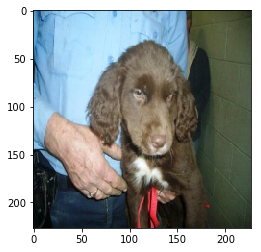


Raw data (first image):


array([[[197., 149.,  91.],
        [193., 146.,  85.],
        [184., 137.,  75.],
        ...,
        [ 32.,  48.,  41.],
        [ 25.,  46.,  38.],
        [ 22.,  45.,  37.]],

       [[199., 152.,  91.],
        [192., 145.,  84.],
        [185., 138.,  76.],
        ...,
        [ 32.,  48.,  41.],
        [ 25.,  46.,  38.],
        [ 24.,  45.,  37.]],

       [[201., 154.,  93.],
        [193., 146.,  85.],
        [187., 139.,  77.],
        ...,
        [ 33.,  49.,  43.],
        [ 29.,  46.,  39.],
        [ 28.,  45.,  38.]],

       ...,

       [[ 25.,  30.,  23.],
        [ 21.,  23.,  17.],
        [ 24.,  21.,  16.],
        ...,
        [ 33.,  41.,  31.],
        [ 31.,  38.,  33.],
        [ 30.,  37.,  32.]],

       [[ 11.,  15.,   9.],
        [ 15.,  17.,  11.],
        [ 25.,  22.,  17.],
        ...,
        [ 32.,  41.,  31.],
        [ 31.,  37.,  32.],
        [ 29.,  36.,  30.]],

       [[ 21.,  25.,  19.],
        [ 19.,  22.,  16.],
        [ 15.,  

In [3]:
%matplotlib inline
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import cv2

# deploy a progress bar
try:
    from tqdm.notebook import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x


# make a list for the name of failed files
fail_dir_list = []

# count the number of valid images that were read
img_counter = 0

for f in tqdm(range(len(filename_list))):
    # read every image file directory
    img_path = data_dir + filename_list[f]
        
    try:
        # Read and resize every image
        img = cv2.imread(img_path, 1)  # 1 : Color
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

        # build the list with feature data [RGB values]
        X[img_counter, :, :, :] = img

        # split image directory name
        fname_split = filename_list[f].split('/')  # =[Cat, 10.jpg] example
        
        # build the list with labels [cats | dogs]
        class_name = fname_split[0]
        y.append(class_name)

        img_counter += 1

    except Exception as e:
        # log names of files with errors
        fail_dir_list.append(img_path)
        pass

# remove empty arrays
X = X[:img_counter]

print('{} invalid file(s) were found\n'.format(len(fail_dir_list)))
print('Printing the resulting dataset :\n')

# plot a sample from the list of images [features]
print('LABEL : ' + y[0])
plt.imshow(cv2.cvtColor(X[0], cv2.COLOR_BGR2RGB).astype(np.uint8))
plt.show()

print('\nRaw data (first image):')
X[0]

##### DATA AUGMENTATION

##### TRANSFORM THE TARGET VALUES TO ONE-HOT ENCODING

In [4]:
y = pd.get_dummies(y)
y.head()

,Cat,Dog
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1


##### SPLIT THE FILE NAMES INTO TRAINING AND TESTING SETS

In [5]:
from sklearn.model_selection import train_test_split

# split the dataset into 2 training and 2 testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.2, random_state=13)

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

print('Data shapes:\n')
print('X_train : {}\ny_train : {}\n\nX_test : {}\ny_test : {}'.format(np.shape(X_train),
                                                                      np.shape(y_train),
                                                                      np.shape(X_test),
                                                                      np.shape(y_test)))

Data shapes:

X_train : (240, 227, 227, 3)
y_train : (240, 2)

X_test : (60, 227, 227, 3)
y_test : (60, 2)


## ------- MODEL TRAINING -------

##### CHECK USE OF AVAILABLE CPU AND GPU

In [6]:
import tensorflow as tf 
from tensorflow.python.client import device_lib
from keras import backend as K

if K.tensorflow_backend._get_available_gpus():
    print('\nAccelerated by GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print('Currently running on CPU....')

print('\n\nList of available devices:')
device_lib.list_local_devices()

Using TensorFlow backend.


Currently running on CPU....


List of available devices:


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10045093951079813303]

##### DEFINE NETWORK PARAMETERS

In [7]:
# extract images properties
n_classes = np.shape(y_train)[1]

# count number of samples in each set of data
n_train = np.shape(X_train)[0]
n_test = np.shape(X_test)[0]

# define amount of neurons
n_layer_in = None          # this will depends on the conv layer configurations
n_layer_h1 = 4096          # first   hidden layer
n_layer_h2 = 4096          # second  hidden layer
n_layer_out = n_classes    # 2 neurons in output layer

sigma_init = 0.01   # for randomized initialization
drop_prob = 0.25    # for the dropout layers

##### NETWORK DESIGN
This notebook tries to explain the CNN model using the ALEXNET architecture design

In [8]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://neurohive.io/wp-content/uploads/2018/10/AlexNet-1.png")

##### MODEL ARCHITECTURE

In [9]:
import tensorflow
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout

###############################################
## ------ CONVOLUTIONAL NEURAL NETWORK ------##    
###############################################
    
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

##############################################
## ------ FEED FORWARD NEURAL NETWORK ------##
##############################################

model.add(Flatten())

model.add(Dense(n_layer_h1, input_shape=X_train.shape[1:]))
model.add(Dropout(drop_prob))
model.add(Activation('relu'))

model.add(Dense(n_layer_h2))
model.add(Dropout(drop_prob))
model.add(Activation('relu'))

model.add(Dense(n_classes))
model.add(Activation('softmax'))
#model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 256)       884992    
__________

##### DEFINE DIRECTORIES FOR RESULTS

In [10]:
import sys
import shutil
from datetime import datetime

# set up the directory to store the results for tensorboard
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_ckpoint = 'output/tf_checkpoints'
root_logdir = 'output/tf_logs'
logdir = '{}/run-{}/'.format(root_logdir, now) 

## Try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree(root_ckpoint)
except OSError as e:
    print ('Error: %s - %s.' % (e.filename, e.strerror))

Error: output/tf_checkpoints - 系統找不到指定的路徑。.


##### MODEL EXECUTION

In [11]:
# define loss function and optimizers
optimizer = keras.optimizers.Adadelta(lr=0.10)
loss = keras.losses.categorical_crossentropy

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

# execute the model
history = model.fit(X_train, y_train, epochs=50, batch_size=5, validation_data=(X_test, y_test))

Train on 240 samples, validate on 60 samples
Epoch 1/50
240/240 [==============================] - 42s 175ms/step - loss: 0.7033 - acc: 0.4667 - val_loss: 0.6928 - val_acc: 0.5167
Epoch 2/50
240/240 [==============================] - 40s 168ms/step - loss: 0.6943 - acc: 0.5042 - val_loss: 0.6919 - val_acc: 0.6167
Epoch 3/50
240/240 [==============================] - 40s 165ms/step - loss: 0.6947 - acc: 0.5083 - val_loss: 0.6922 - val_acc: 0.5167
Epoch 4/50
240/240 [==============================] - 40s 167ms/step - loss: 0.6934 - acc: 0.5083 - val_loss: 0.6911 - val_acc: 0.5167
Epoch 5/50
240/240 [==============================] - 40s 166ms/step - loss: 0.6925 - acc: 0.5292 - val_loss: 0.6892 - val_acc: 0.6000
Epoch 6/50
240/240 [==============================] - 40s 165ms/step - loss: 0.6927 - acc: 0.5167 - val_loss: 0.6909 - val_acc: 0.5167
Epoch 7/50
240/240 [==============================] - 40s 167ms/step - loss: 0.6912 - acc: 0.5333 - val_loss: 0.6858 - val_acc: 0.6333
Epoch 8/50

##### VISUALIZE THE ACCURACY RESULTS

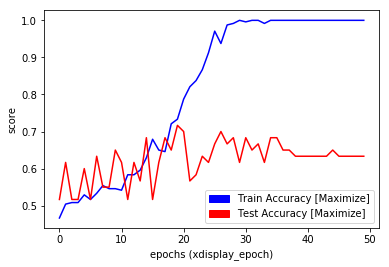

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# set up legend
blue_patch = mpatches.Patch(color='blue', label='Train Accuracy [Maximize]')
red_patch = mpatches.Patch(color='red', label='Test Accuracy [Maximize]')
plt.legend(handles=[blue_patch,red_patch])

#plot the data
plt.plot(history.history['acc'], color='blue')
plt.plot(history.history['val_acc'], color='red')

plt.xlabel('epochs (x{})'.format('display_epoch'))
plt.ylabel('score');